# Dataset shift

In the previous assignment you have worked with wafer map data from a semiconductor manufacturing process, and developed a calibrated binary classifier for identifying whether a finished wafer contains a known pattern of faulty chips.

Imagine the company has evaluated several classifiers and deployed one of them in production, as part of a larger system for identifying the root causes of faulty chips. The root cause analysis relies on the expertise of human operators. When the root cause of faulty chips on a wafer can be identified, the process parameters can be adjusted, reducing the number of faulty chips and increasing wafer yield.

Ideally, the company would like all wafers to be analyzed by the operators, however, their capacity is limited. Therefore, the classifier is used as part of a filtering stage to select wafers which are suitable for further analysis by the operators, based on whether the wafers contain a known pattern of faulty chips.

After a month, the company observes degrading wafer yield. They suspect it is due to a drop in classification performance of the classifier: missing wafers that are suitable for further analysis will prevent the operators from identifying the root causes of faulty chips and adapting the process parameters, resulting in more faults and lower yield. Your task is to investigate this suspicion.

#### Overview

You are given two datasets: a labeled *training* set that represents the data used to train the classifier and a partially labeled *production* set representing the data collected after the model was deployed in production. Both datasets are based on the WM-811K dataset containing annotated wafer maps collected from real-world fabrication (see `./data/readme.txt`).

You are also given the implementation of the deployed classifier.

The assignment consists of two parts:

- Part 1 is about defining the data mining objective.
- Part 2 is about addressing the data mining objective.

#### Deliverables

There are two deliverables for this assignment:

- Report: it should be max 4 pages long (double column). It's structure should follow the CRISP-DM process. A template is provided in the assignment on Canvas. The report will be graded.
- This notebook: it must contain all the supporting material for the report, i.e. all the results and figures must be generated in this notebook. This notebook will not be graded, however, missing supporting material for the report will affect the grade of the report.

Deliver a `.zip` archive with three files:

- `dataset_shift_<groupid>.pdf` file containing the report,
- `dataset_shift_<groupid>.ipynb` file containing this filled in **and executed** notebook,
- `dataset_shift_<groupid>.html` file containing this filled in **and executed** notebook rendered to html,

by submitting it to the corresponding assignment on Canvas. `<groupid>` refers to your group number on Canvas. You may submit as many times as you like before the deadline. The last submission counts.

Throughout this notebook you will find cells starting `# // BEGIN_TODO`.

- Fill in all your code between these `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]` tags.
- Do not edit these tags in any way, or else your answers may not be processed by the grading system.
- You can add as many code and text cells as you want between the `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]` tags to make your code nicely readable.
- Unlike the previous assignment, your submitted notebook will *not* be evaluated by Momotor. You are free to use any libraries you like, but make sure you import all your libraries between the `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]` tags.

You are encouraged to play with the data and extend this notebook in order to obtain your answers. You may insert cells at any point in the notebook, but remember:
<br/><br/>
<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
Only the code in your answer cells (i.e. between `# // BEGIN_TODO` and `# // END_TODO`) will be extracted and evaluated.
</div>

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
Before delivering your notebook, make sure that the cells in your notebook can be executed in sequence without errors, by executing "Restart & Run All" from the "Kernel" menu.
</div>

Let's get started by filling in your details in the following answer cell. Assign your group number, your names and student ids to variables `group_number`, `name_student1`, `id_student1`, `name_student2`, `id_student2`, e.g.:

```
# // BEGIN_TODO [AUTHOR]
group_number = "7"
name_student1 = "John Smith"
id_student1 = "1234567"
name_student2 = "Jane Miller"
id_student2 = "7654321"
# // END_TODO [AUTHOR]
```

In [1]:
#// BEGIN_TODO [AUTHOR]

group_number = "24"
name_student1 = "Ambarish Moharil"
id_student1 = "1704818"
name_student2 = "Saptarshi Chakravarty"
id_student2 = "7654321"

#// END_TODO [AUTHOR]

## Import libraries

You are free to use any libraries you like. However, please import any additional libraries between `# // BEGIN_TODO [CODE]` and `# // END_TODO [CODE]` tags in Part 2.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load the data

The training data, that was used to train the classifier before deployment, resides in the `./data/wafer_training.pkl` pickle file.

In [3]:
with open('./data/wafer_training.pkl', 'rb') as f:
    X_train, y_train = pickle.load(f)

In [4]:
X_train.shape

(2624, 26, 26)

`X_train` contains the wafer maps and `y_train` contains the labels. The maps are 26x26 pixels, a pixel of value 0 represents the background, a pixel of value 1 indicates a good chip, and a pixel of value 2 indicates a bad chip. An example of a wafer map is shown below.

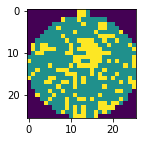

In [5]:
fig, axes = plt.subplots(1, figsize = (2,2))
plt.imshow(X_train[0]);

The production data, that was collected after the classifier was deployed in production, resides in the `./data/wafer_production.pkl` pickle file.

In [6]:
with open('./data/wafer_production.pkl', 'rb') as f:
    X_production, y_production = pickle.load(f)

In [7]:
X_production.shape

(7953, 26, 26)

In [8]:
# Create a Test Set
X_test = X_production[-867:]
y_test = y_production[-867:]

# Production List
X_prod_list = []
y_prod_list = []
for idx in range(0,7085):
    X_prod_list.append(X_production[idx])
    y_prod_list.append(y_production[idx])
X_production = np.array(X_prod_list)
y_production = np.array(y_prod_list)

`X_production` contains the wafer maps and `y_production` contains the labels. The samples are listed in the same order as they were collected.

The wafer maps were labeled by human experts according to whether the wafer map contains a known bad chip pattern or not:

- 1: a pattern (one of the 8 patterns in the Calibration assignment)
- 0: no pattern
- -1: unlabeled sample

You will observe that `y_production` is only partially labeled, i.e. some samples are unlabeled. You can imagine that labeling is time consuming and expensive process and only a subset was labeled, e.g. for monitoring the performance of the classifier.

An example of the wafer map with and without known pattern is shown below.

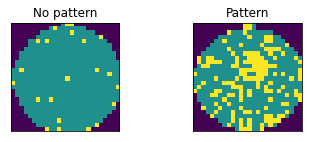

In [9]:
unique_classes, class_indexes = np.unique(y_train,return_index=True)
class_names = ["No pattern", "Pattern"]
fig, axes = plt.subplots(1,2, figsize = (6,2))
for num_index, index in enumerate(class_indexes):
    axes[num_index].imshow(X_train[index])
    axes[num_index].set_title(class_names[unique_classes[num_index]])
    axes[num_index].set_xticks([])
    axes[num_index].set_yticks([])

## Define the classifier

Here is the implementation of the deployed classifier. It is a multi-layer perceptron with one hidden layer containing 10 neurons, that is trained using the Adam optimizer with early stopping. It expects a vector as input.

In [10]:
from sklearn.neural_network import MLPClassifier

deployed_classifier = MLPClassifier(hidden_layer_sizes=(10), early_stopping=True, tol=1e-4, validation_fraction=0.1,
                                n_iter_no_change=20, solver="adam", max_iter=100, random_state=1)

## Part 1: identify the data mining objective

Think of a data mining objective that can be derived from the description above. The objective should be general enough to prevent similar problems from occurring in the future. We will discuss your objectives during the lab session on October 6th and decide on a common objective to be addressed by all groups (it will be posted on Teams for those unable to attend the lab session). Feel free to explore the data.

In [11]:
# TODO: Explore the data

#PLAN OF ACTION : 

#okay so we need to detect when the dataset shift is happening.
#our plan:- 
#we will construct a VAE (Variational AutoEncoder), which we will train on the input distribution of our data and measure the recons and 
# KL Divergence loss. Further more, to obtain the best reconstruction our obj would be to max the PR-AUC.
#Once we have done this, we will look at the production dataset and look for the drop in the PR AUC metric.
#For those samples, we will get the MLP clf predictions and investigate if the clf is giving a poor perf.
#If that is indeed the case, then we can say for sure that the samples are OOD.


In [12]:
#Chunk the production set in a sequential manner 



In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.4, random_state = 42)

In [14]:
#Evaluate the classifier

deployed_classifier.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]), y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=10, max_iter=100,
              n_iter_no_change=20, random_state=1)

In [15]:
y_pred = deployed_classifier.predict(X_val.reshape(X_val.shape[0],X_val.shape[1]*X_val.shape[2] ))

In [16]:
#We will evaluate the classifier on our validation set

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score,  confusion_matrix
recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)

f1_score =  2 * (precision * recall) / (precision + recall)

print(f'The mean recall score of the model on the validation set is {recall}')
print(f'The mean precision score of the model on the validation set is {precision}')
print(f'The mean F1 score of the model on the validation set is {f1_score}')

The mean recall score of the model on the validation set is 0.6867924528301886
The mean precision score of the model on the validation set is 0.91
The mean F1 score of the model on the validation set is 0.7827956989247311


In [18]:
#Create the dataset class
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from torch import nn


class CreateDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, requires_grad= True, dtype = torch.float32)
        self.targets = torch.tensor(targets, dtype = torch.float32)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        
        return len(self.data) 


In [19]:
#dataset class for unknown data points
class CreateDatasetUnknown(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, requires_grad= True, dtype = torch.float32)

    def __getitem__(self, index):
        x = self.data[index]

        return x
    
    def __len__(self):
        
        return len(self.data) 

In [20]:
#First get a set of labelled samples from the production data

X_production_labelled_list = []
y_production_labelled_list = []

X_production_unalabelled_list = []

for i in range(len(y_production)):
    if y_production[i] != -1:
        X_production_labelled_list.append(X_production[i])
        y_production_labelled_list.append(y_production[i])
    else:
        X_production_unalabelled_list.append(X_production[i])


X_production_lab = np.array(X_production_labelled_list)
y_production_lab = np.array(y_production_labelled_list)

X_production_unlab = np.array(X_production_unalabelled_list)

In [21]:
X_production_lab.shape


(2361, 26, 26)

In [113]:
# 5 and 13 are the divisors of 2361

#So we can try detecting by dividing the data in 3 sets 
#chunk 1 [0-787]

def split_array(arr, start_rng, end_rng, axis):
    split_arr = np.split(arr, [start_rng, end_rng], axis=0)
    return split_arr[1]

#set 1
X_production1 = split_array(X_production_lab, 0,787, 0)
y_production1 = split_array(y_production_lab, 0,787, 0)

#set2
X_production2 = split_array(X_production_lab, ((787*1) + 1),((787*2)), 0)
y_production2 = split_array(y_production_lab,  ((787*1) + 1),((787*2)), 0)

#set3
X_production3 = split_array(X_production_lab,  ((787*2) + 1),((787*3)), 0)
y_production3 = split_array(y_production_lab,  ((787*2) + 1),((787*3)), 0)

In [114]:
#create the training dataloader
train_dataset = CreateDataset(X_train,y_train)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=10)

#create the validation dataloader
val_dataset = CreateDataset(X_val,y_val)
val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=10)

In [115]:
#for production datasets - labelled
prod_dataset_lab1 = CreateDataset(X_production1,y_production1)
prod_dataloader_lab1 =  torch.utils.data.DataLoader(prod_dataset_lab1, batch_size=10)

prod_dataset_lab2 = CreateDataset(X_production2,y_production2)
prod_dataloader_lab2 =  torch.utils.data.DataLoader(prod_dataset_lab2, batch_size=10)

prod_dataset_lab3 = CreateDataset(X_production3,y_production3)
prod_dataloader_lab3 =  torch.utils.data.DataLoader(prod_dataset_lab3, batch_size=10)

In [116]:
from collections import Counter
Counter(y_production1)

Counter({0: 408, 1: 379})

In [117]:
#for production datasets - unlabelled
prod_dataset_unlab = CreateDatasetUnknown(X_production_unlab)
prod_dataloader_unlab =  torch.utils.data.DataLoader(prod_dataset_unlab, batch_size=10)

In [26]:
import numpy as np
import pickle
import requests
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc


#Create a Variational Autoencoder

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.input_layer = nn.Linear(input_dim, hidden_dim) 
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.sigma_layer = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, batch_input):
        
        
        h = nn.ReLU()(self.input_layer(batch_input)) #[N X H], H = hidden_dim, N = batch_size
        h = nn.ReLU()(self.hidden_layer(h)) #[N X H]
        
        mu = self.mu_layer(h)
        log_sigma = self.sigma_layer(h)
        
        z = self.reparam(mu, log_sigma)
        
        return z, mu, log_sigma
    
    def reparam(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(sigma) #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        
        z = mu + sigma*eps
        
        return z
    
#The encoder has now encoded the the input into an L dim latent vector Z, we need to decode z in order to sample from p(x)
#Thus we define a decoder 

class Decoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, output_dim):
        super(Decoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        self.hidden_layer1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        
        h_o = nn.ReLU()(self.hidden_layer1(z))
        h_o = nn.ReLU()(self.hidden_layer2(h_o))
        
        reconstruction = nn.Sigmoid()(self.out(h_o))
        
        return reconstruction
        
#Now we can define the VAE

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, batch_input):
        
        z, mu, log_sigma = self.encoder(batch_input)
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, log_sigma, z
    


In [52]:
# code for model definitions goes here
class ConvEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, imgChannels =1, featureDim = 128*5*5):
        super(ConvEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 64, 3, stride =1) # 16x30x30
        self.batchNorm1 = nn.BatchNorm2d(64)
        self.maxPool1 = nn.MaxPool2d(2) # 16 x 15 x 15
        self.encConv2 = nn.Conv2d(64, 128, 3, stride =1) # 32 x 13x 13
        self.batchNorm2 = nn.BatchNorm2d(128)
        self.maxPool2 = nn.MaxPool2d(2) # 32x6x6
        
        self.dropout = nn.Dropout(0.5)
        self.encFC1 = nn.Linear(featureDim, latent_dim)
        self.encFC2 = nn.Linear(featureDim, latent_dim)

        
        #self.input_layer = nn.Linear(out_channels*32*32, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.mu_layer = nn.Linear(featureDim, latent_dim)
        self.sigma_layer = nn.Linear(featureDim, latent_dim)
        
    def forward(self, batch_input):
        
        #Conv Block 1
        h = self.encConv1(batch_input) #[N X H], H = hidden_dim, N = batch_size
        h = self.batchNorm1(h)
        h = nn.ReLU()(self.maxPool1(h))
#         Conv Block 2
        h = self.encConv2(h) #[N X H], H = hidden_dim, N = batch_size
        h = self.batchNorm2(h)
        h = nn.ReLU()(self.maxPool2(h)) 
        h = h.view(-1, 128*5*5)
        
        h = self.dropout(h)
        mu = self.mu_layer(h)
        log_sigma = self.sigma_layer(h)
        
        z = self.reparam(mu, log_sigma)
        
        return z, mu, log_sigma
    
    def reparam(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(sigma) #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        
        z = mu + sigma*eps
        
        return z
    
#The encoder has now encoded the the input into an L dim latent vector Z, we need to decode z in order to sample from p(x)
#Thus we define a decoder 

class ConvDecoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, output_dim, imgChannels =1, featureDim = 128*22*22):
        super(ConvDecoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(latent_dim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(128, 64, 3)
        self.decConv2 = nn.ConvTranspose2d(64, imgChannels, 3)

        
    def forward(self, z):
        
        h_o = nn.ReLU()(self.decFC1(z))
        
        h_o = h_o.view(-1, 128,22,22)
        
        h_o = nn.ReLU()(self.decConv1(h_o))

        reconstruction = nn.Sigmoid()(self.decConv2(h_o))
        
        return reconstruction
        
#Now we can define the VAE

class ConvVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(ConvVAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, batch_input):
        
        z, mu, log_sigma = self.encoder(batch_input)
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, log_sigma,z
   

In [53]:
#We need to define the KL-Divergence loss and the reconstruction loss
def loss_function(x, x_reconstr, mu, log_sigma,reduce=True):
    if reduce:
        reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
        kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
        total_loss = reconstr_loss + kl_loss
    else:
        reconstr_loss =torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=(1))
        kl_loss =  0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
        total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

In [54]:
# #Instantiate the classes ---VAE
# cuda = True
# DEVICE = torch.device("cuda" if cuda else "cpu")
# x_dim = 26*26
# latent_dim = 5
# hidden_dim = 500
# batch_size = 10
# lr = 6e-04
# epochs = 11

# encoder = Encoder(input_dim = x_dim, hidden_dim = hidden_dim, latent_dim = latent_dim).cuda()
# decoder = Decoder(hidden_dim = hidden_dim, latent_dim = latent_dim, output_dim = x_dim).cuda()

# vae = VAE(encoder = encoder, decoder = decoder).cuda()

In [55]:
#Instantiate the classes ---CONV VAE
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
x_dim = 26*26
latent_dim = 5
hidden_dim = 500
batch_size = 10
lr = 6e-04
epochs = 50

convencoder = ConvEncoder(input_dim = x_dim, hidden_dim = hidden_dim, latent_dim = latent_dim).cuda()
convdecoder = ConvDecoder(hidden_dim = hidden_dim, latent_dim = latent_dim, output_dim = x_dim).cuda()
conv_vae = ConvVAE(encoder = convencoder, decoder = convdecoder).cuda()

In [56]:
#Train the VAE - objective : min KL Loss, max PR-AUC score

def compute_val_metric(model, val_loader):
    losses, targets = [], []
    with torch.no_grad():
        model.eval()
        for batch_idx, val_data in enumerate(val_loader):
            x, y = val_data
            if x.size()[0] == 10:
                #x = x.view(batch_size, x_dim)
                x = torch.unsqueeze(x,1)
                x = x.to(DEVICE)
                outputs, mu, log_sigma,z = model.forward(x)
                outputs = outputs.view(10,26*26) #batch_size, x_dim
                x = x.view(10,26*26) #batch_size, x_dim
                loss, reconstruction_loss, kl_loss = loss_function(x, outputs,mu, log_sigma, reduce = False)
                losses.append(loss)
                targets.append(y)
                
    scores = torch.stack(losses, axis=0).view(-1)
    targs = torch.stack(targets, axis=0).view(-1)
    #scale the scores - min-max scaling (for the predicted probabilities)
    scores = (scores - scores.min())/(scores.max() - scores.min())
    scores = scores.cpu().detach().numpy()
    fpr, tpr, roc_thresholds = roc_curve(targs, scores)
    precision, recall, pr_thresholds = precision_recall_curve(targs, scores)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    
    return fpr,tpr,precision,recall,roc_auc,pr_auc, pr_thresholds, roc_thresholds

optimizer = Adam(conv_vae.parameters(), lr=lr)
print("Start training VAE...")

conv_vae.train()

for epoch in range(epochs):
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, data in enumerate(train_dataloader):
        x, y = data
        if x.size()[0] == 10:
            #x = x.view(batch_size, x_dim)
            x = torch.unsqueeze(x,1)
            x = x.to(DEVICE)
            optimizer.zero_grad()
            x_reconstr, mu, log_sigma, z = conv_vae(x)
            loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)

            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()

            loss.backward()
            optimizer.step()
        
    n_datapoints = batch_idx * batch_size
    fpr,tpr,precision,recall,roc_auc,pr_auc, pr_thresholds, roc_thresholds = compute_val_metric(conv_vae,val_dataloader)


    
    
    
    print("\tEpoch", epoch + 1, "\nAverage Loss: ", overall_loss / n_datapoints)
    print("\nReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints, 
         "  \tVal PR_AUC", pr_auc)
    print('\n')
    
print("Training complete!")

Start training VAE...
	Epoch 1 
Average Loss:  174.88333405901673

Reconstruction Loss: 166.6295491018113 	KL Loss: 8.253785511186928   	Val PR_AUC 0.8795362638131731


	Epoch 2 
Average Loss:  120.15666192899084

Reconstruction Loss: 115.57671190006718 	KL Loss: 4.579949914725723   	Val PR_AUC 0.8784929714619655


	Epoch 3 
Average Loss:  107.67597492971238

Reconstruction Loss: 103.08050653737062 	KL Loss: 4.595468067971005   	Val PR_AUC 0.8796984159230274


	Epoch 4 
Average Loss:  104.52449161991193

Reconstruction Loss: 99.82810991615247 	KL Loss: 4.696381509379976   	Val PR_AUC 0.880777161446872


	Epoch 5 
Average Loss:  103.380946223751

Reconstruction Loss: 98.78380099739998 	KL Loss: 4.597144869178724   	Val PR_AUC 0.8815356340570202


	Epoch 6 
Average Loss:  102.13868699772343

Reconstruction Loss: 97.72058536991192 	KL Loss: 4.4181013969858745   	Val PR_AUC 0.8804056702742724


	Epoch 7 
Average Loss:  101.1888797832902

Reconstruction Loss: 96.89089650925557 	KL Loss: 4.2

In [61]:
# We will have to evaluate our VAE and visualize some reconstructed images

#Visualizing the out of distribution datapoints:
def show_images(x, ncols=10):
    x = x.view(-1, 26, 26)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy())
        ax[idx].axis('off')
    plt.show()




def detect_shift(model, data_loader, target_flag):
    elbo_list = []
    recon_list = []
    model.eval()
    with torch.no_grad():
        for batch_idx, _data in enumerate(data_loader):
            if target_flag == True:
                x, y = _data
            else:
                x = _data
            if x.size()[0] == 10:
                #x = x.view(batch_size, x_dim)
                x = torch.unsqueeze(x,1)
                x = x.to(DEVICE)
                outputs, mu, log_sigma,z = model.forward(x)
                outputs = outputs.view(10,26*26) #batch_size, x_dim
                x = x.view(10,26*26) #batch_size, x_dim
                loss, reconstruction_loss, kl_loss = loss_function(x, outputs,mu, log_sigma, reduce = False)
                elbo_list.append(loss.cpu().numpy())
                recon_list.append(reconstruction_loss.cpu().numpy())
#                 show_images(outputs)
                
                
    elbo_ = np.concatenate(elbo_list, 0)
    recon_ = np.concatenate(recon_list, 0)
    return elbo_, recon_       

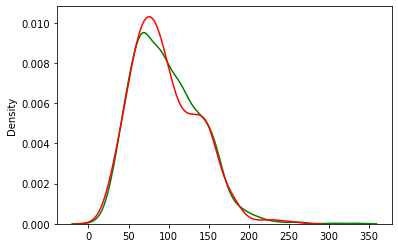

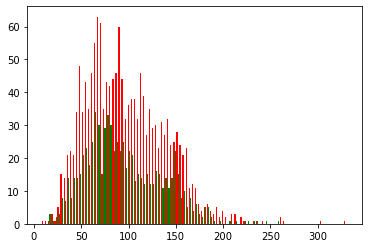

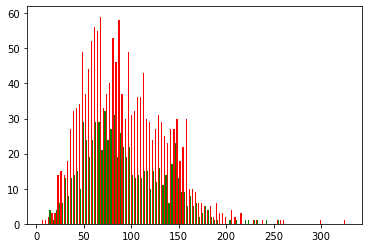

KstestResult(statistic=0.04466764657847461, pvalue=0.2401698030629663)


In [122]:
#Let us investigate the labelled production data and see if see anything


#Results PROD SET 1

import seaborn as sns

elbo_train, recon_train = detect_shift(conv_vae, train_dataloader, target_flag = True)

elbo_prod_lab1, recon_prod_lab1 = detect_shift(conv_vae, prod_dataloader_lab1, target_flag = True )



sns.kdeplot(elbo_train, color='green')
sns.kdeplot(elbo_prod_lab1, color='red')
plt.show()


plt.hist([elbo_train, elbo_prod_lab1], 100, color=['r', 'g'])
plt.show()


plt.hist([recon_train, recon_prod_lab1], 100, color=['r', 'g'])
plt.show()


#KS TEST

from scipy import stats

test_1 = stats.kstest(elbo_train, elbo_prod_lab1)
print(test_1)

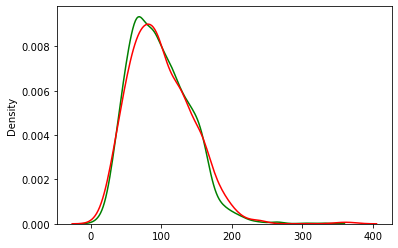

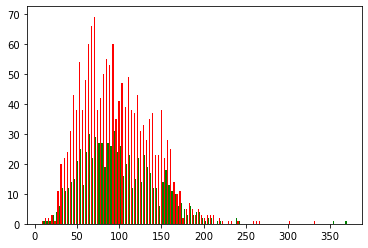

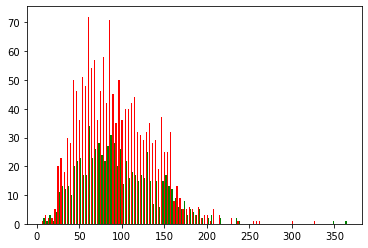

KstestResult(statistic=0.0333823289237302, pvalue=0.591349210341811)


In [120]:

#RESULTS PROD SET 2

import seaborn as sns

elbo_train, recon_train = detect_shift(conv_vae, train_dataloader, target_flag = True)

elbo_prod_lab2, recon_prod_lab2 = detect_shift(conv_vae, prod_dataloader_lab2, target_flag = True )



sns.kdeplot(elbo_train, color='green')
sns.kdeplot(elbo_prod_lab2, color='red')
plt.show()


plt.hist([elbo_train, elbo_prod_lab2], 100, color=['r', 'g'])
plt.show()


plt.hist([recon_train, recon_prod_lab2], 100, color=['r', 'g'])
plt.show()


# KS TEST

from scipy import stats

test_2 = stats.kstest(elbo_train, elbo_prod_lab2)
print(test_2)

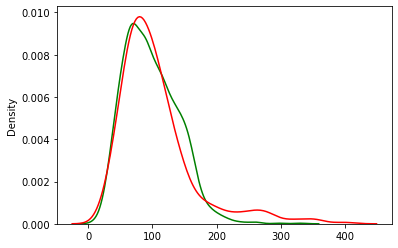

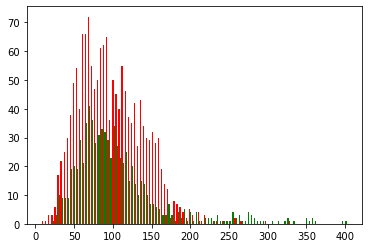

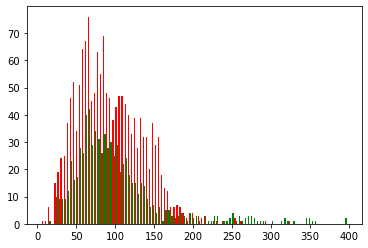

KstestResult(statistic=0.06811203658337417, pvalue=0.014959108882163119)


In [121]:

#RESULTS PROD SET 3

import seaborn as sns

elbo_train, recon_train = detect_shift(conv_vae, train_dataloader, target_flag = True)

elbo_prod_lab3, recon_prod_lab3 = detect_shift(conv_vae, prod_dataloader_lab3, target_flag = True )



sns.kdeplot(elbo_train, color='green')
sns.kdeplot(elbo_prod_lab3, color='red')
plt.show()


plt.hist([elbo_train, elbo_prod_lab3], 100, color=['r', 'g'])
plt.show()


plt.hist([recon_train, recon_prod_lab3], 100, color=['r', 'g'])
plt.show()


# KS TEST

from scipy import stats

test_3 = stats.kstest(elbo_train, elbo_prod_lab3)
print(test_3)

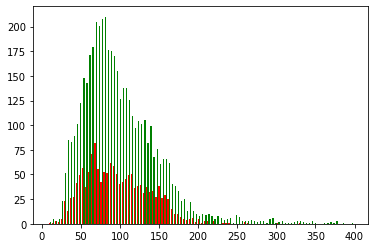

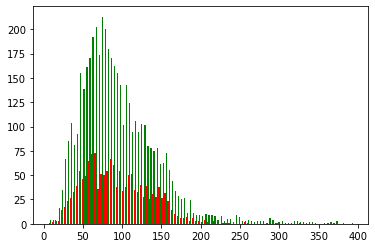

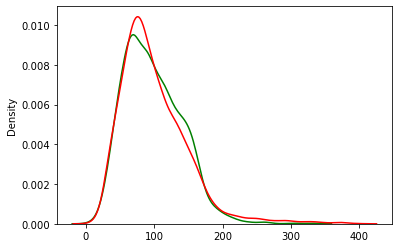

KstestResult(statistic=0.0314706358631113, pvalue=0.18877257490364874)


In [125]:
#Now we investigate the unlabelled data

elbo_prod_unlab, recon_prod_unlab = detect_shift(conv_vae, prod_dataloader_unlab, target_flag = False )


plt.hist([elbo_train, elbo_prod_unlab], 100, color=['r', 'g'])
plt.show()


plt.hist([recon_train, recon_prod_unlab], 100, color=['r', 'g'])
plt.show()


sns.kdeplot(elbo_train, color='green')
sns.kdeplot(elbo_prod_unlab, color='red')
plt.show()

from scipy import stats

test_4 = stats.kstest(elbo_train, elbo_prod_unlab)
print(test_4)

In [ ]:
###############################################################################################################

In [126]:
#How does the model perform on the labelled production data?

y_pred_prod_lab = deployed_classifier.predict(X_production_lab.reshape(X_production_lab.shape[0],
                                                            X_production_lab.shape[1]*X_production_lab.shape[2]))

recall_prod = recall_score(y_production_lab, y_pred_prod_lab)
precision_prod = precision_score(y_production_lab, y_pred_prod_lab)

f1_score_prod =  2 * (precision_prod * recall_prod) / (precision_prod + recall_prod)

print(f'The mean recall score of the model on the production set is {recall_prod}')
print(f'The mean precision score of the model on the production set is {precision_prod}')
print(f'The mean F1 score of the model on the production set is {f1_score_prod}')

The mean recall score of the model on the production set is 0.5308016877637131
The mean precision score of the model on the production set is 0.8859154929577465
The mean F1 score of the model on the production set is 0.6638522427440633


So the false negativity rate of the classifier has increased.The relevant number of items retrieved is low.
- The model still gives relatively low false positives 
- We get an indication that the model recognizes a pattern but for some images it is being predicted that there is no pattern and we should investigate this.

In [97]:
#Investigate the ELBO Density plots for the Val and labelled and unlabelled production sets.

KS-Test : two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.

In [ ]:
from scipy import stats

test_1 = stats.kstest(elbo_train, elbo_prod_lab)
test_2 = stats.kstest(elbo_train, elbo_prod_unlab)

print(test_1)
print(test_2)

    p-value < 0.05, enough evidence to reject the null hypothesis - test_1.
    p-value > 0.05, not enough evidence to reject the null hypothesis - test_2.

We see that the performance of the model on the production set drops. From analyzing the density plots obtained by computing the ELBO (Evidence Lower Bound) of our Variational Autoencoder, and performing KS test on the ELBO (= likelihood scores) of the train and production datasets, we identify that these two distributions are indeed different and there is a shift occurring somewhere in the production labelled set.

Given the ELBO (= approximate likelihood) scores, we can choose a threshold and classify all instances with a likelihood below the threshold as anomalies, and all instances with a likelihood above the threshold as "normal"

In [ ]:
#//TODO : Identify the anamolies in the labelled production set.

In [127]:
#Flip the ELBO Scores. 
# Anomalous flipped ELBO scores should be close to 1, whereas Normal Flipped ELBO scores should be close to 0

elbo_prod_lab3 = (elbo_prod_lab3 - elbo_prod_lab3.min())/(elbo_prod_lab3.max() - elbo_prod_lab3.min())

In [128]:
#Getting the PR-AUC curve for the labelled production dataset

fpr,tpr,precision,recall,roc_auc,pr_auc, pr_thresholds, roc_thresholds = compute_val_metric(conv_vae,prod_dataloader_lab3)

We need to compute the best threshold for our model:
    
    We have a class imbalance (Counter({0: 1593, 1: 1636}))
    - compute G-mean for the best threshold
    - test the model with each threshold returned from the call roc_auc_score() and
      select the threshold with the largest G-Mean value

In [129]:
gmeans = (tpr * (1-fpr))**(1/2)
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (roc_thresholds[ix], gmeans[ix]))

Best Threshold=0.190518, G-Mean=0.763


roc_auc=0.8433660448841063


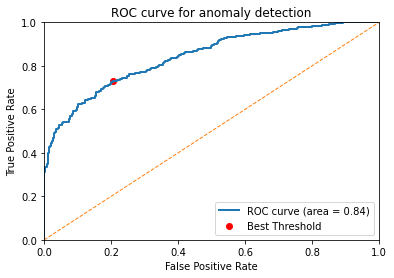

In [130]:
print(f'{roc_auc=}')
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best Threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for anomaly detection')
plt.legend(loc='lower right')
plt.show()

ROC Curve: Interpretation

    Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
    Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

In [131]:
#Best Threshold for PR-Curve
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (pr_thresholds[ix], fscore[ix]))

Best Threshold=0.147270, F-Score=0.761


pr_auc=0.870777467500471


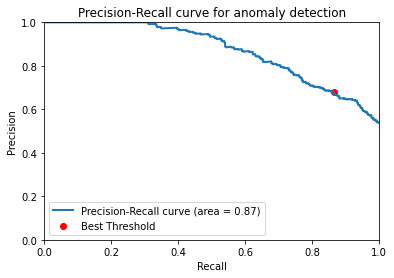

In [132]:
print(f'{pr_auc=}')
plt.figure()
plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.scatter(recall[ix], precision[ix], marker='o', color='red', label='Best Threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for anomaly detection')
plt.legend(loc='lower left')
plt.show()

In [133]:
#Threshold calibration: The threshold will define the TP/FP etc rate.

#There is not enough imbalance so we will look at the best threshold from the ROC curve 

thresh = 0.147270
ood_vals = [i for i in elbo_prod_lab3 if i > thresh]

In [134]:
#Out of distribution datapoints
ood_datapoints = [i for i in range(len(elbo_prod_lab3)) if elbo_prod_lab3[i] > thresh]

In [135]:
print(f'Number of out of distribution datapoints are {len(ood_datapoints)} out of total {len(elbo_prod_lab)} datapoints')

Number of out of distribution datapoints are 498 out of total 780 datapoints


In [136]:
X_production_ood_list = []
y_production_ood_label_list = []
for idx in ood_datapoints:
    X_production_ood_list.append(X_production3[idx])
    y_production_ood_label_list.append(y_production3[idx])

X_production_ood = np.array(X_production_ood_list)
y_production_ood = np.array(y_production_ood_label_list)

In [137]:
ood_dataset = CreateDataset(X_production_ood, y_production_ood)
ood_dataloader =  torch.utils.data.DataLoader(ood_dataset, batch_size=10)

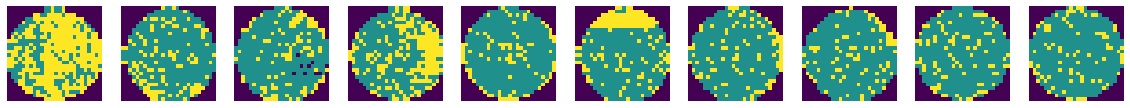

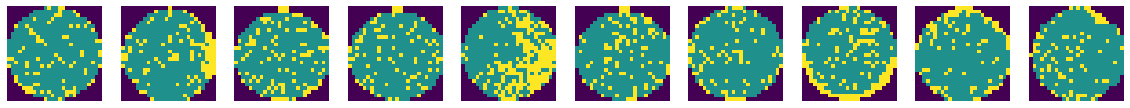

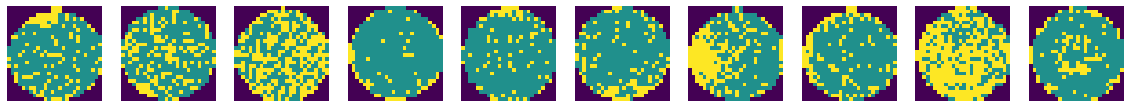

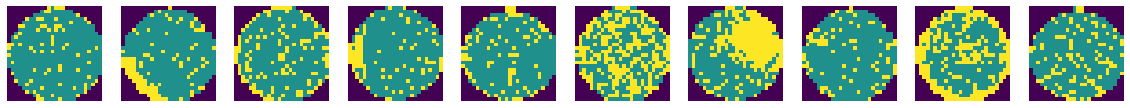

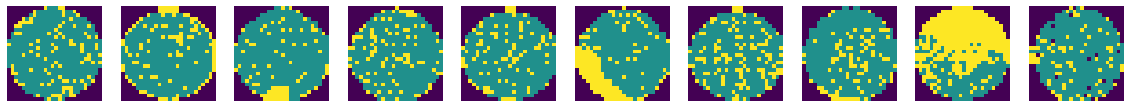

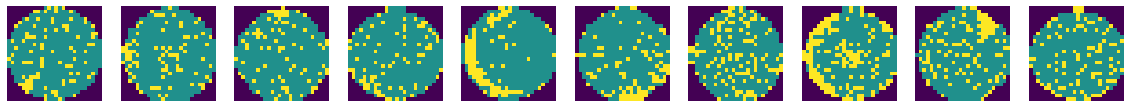

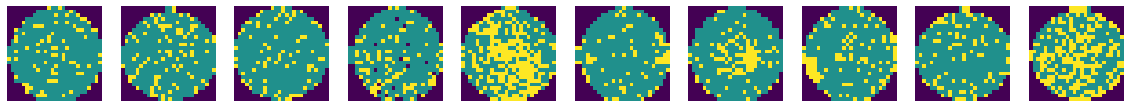

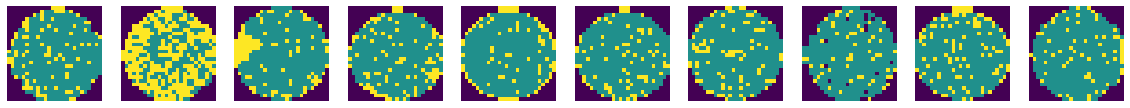

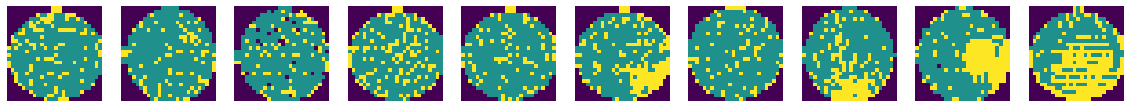

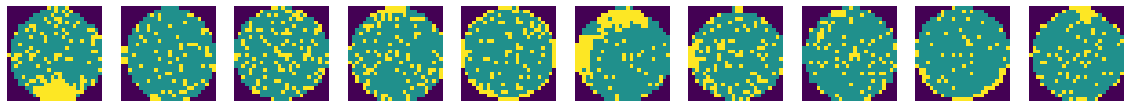

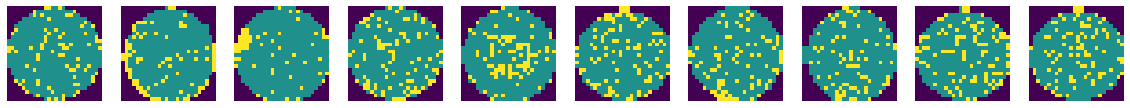

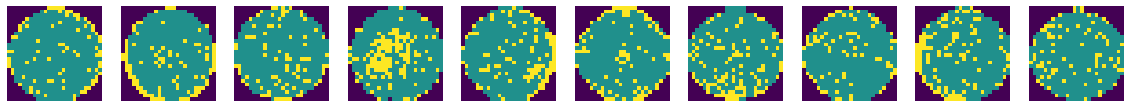

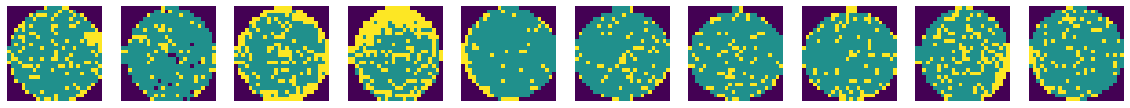

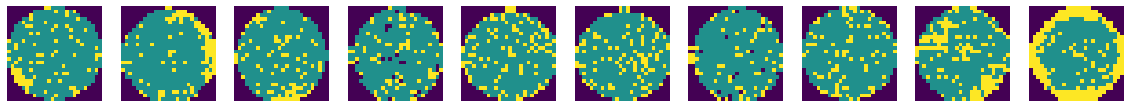

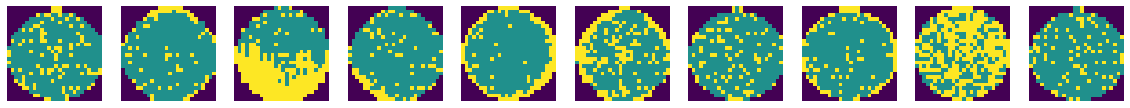

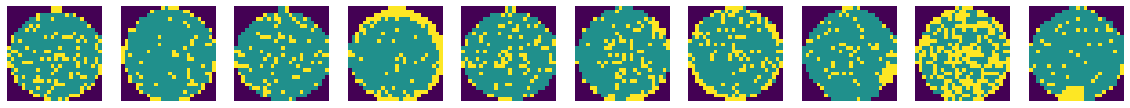

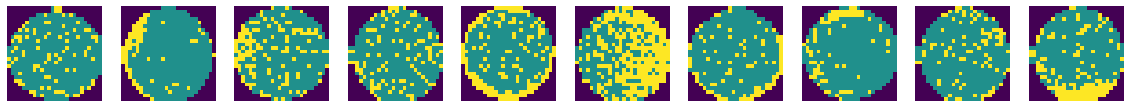

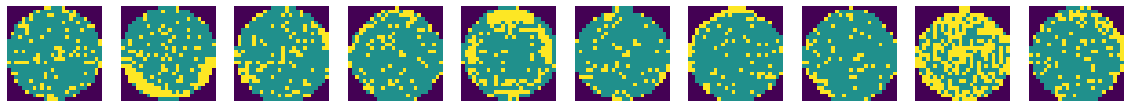

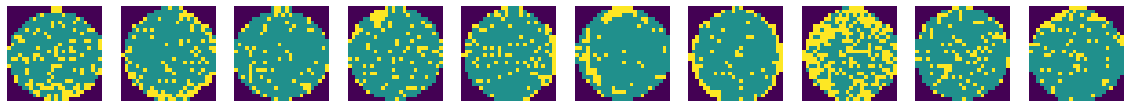

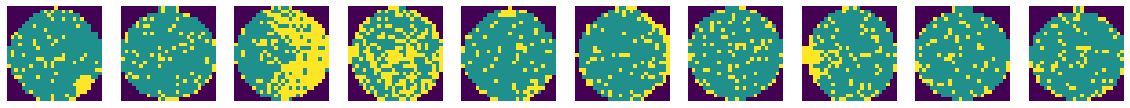

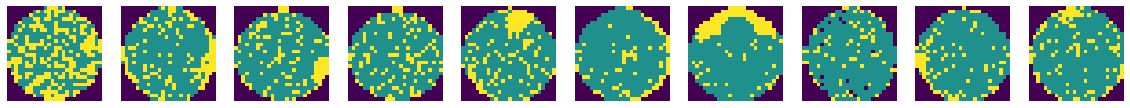

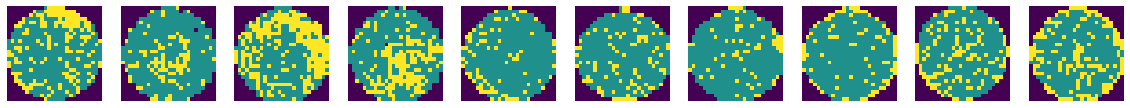

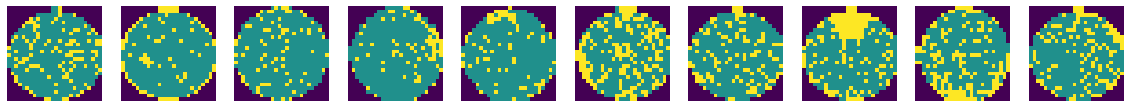

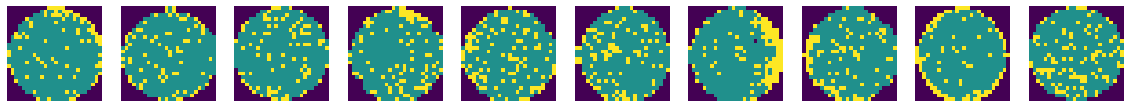

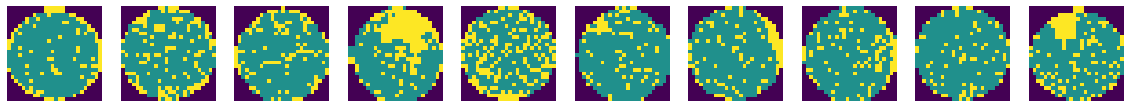

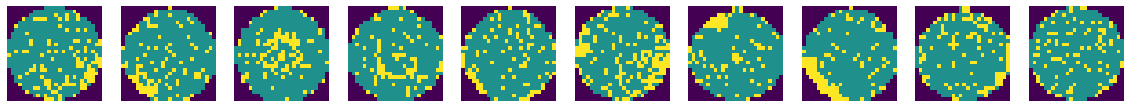

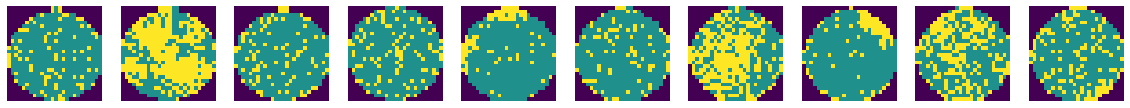

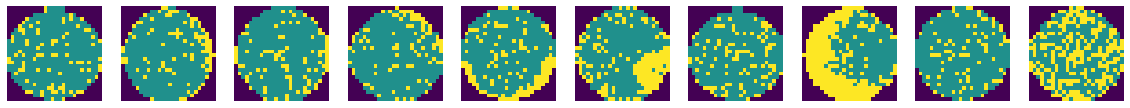

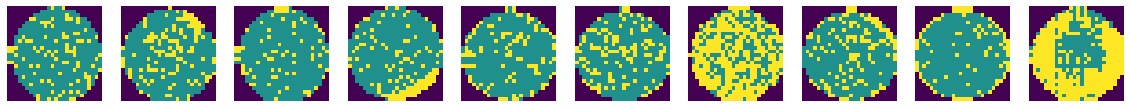

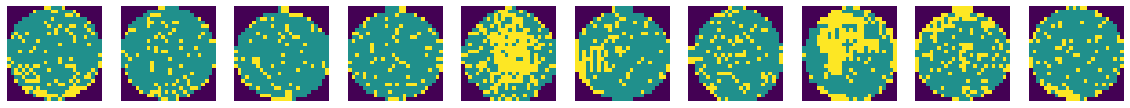

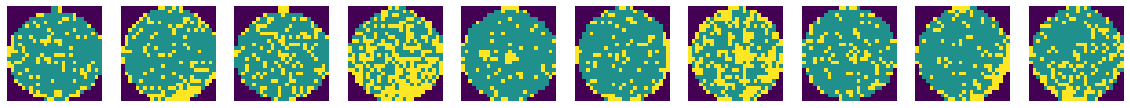

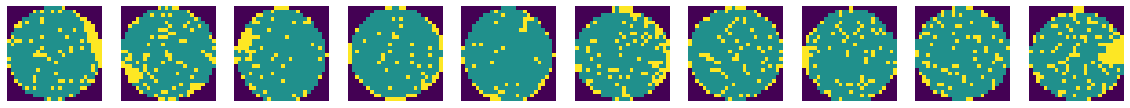

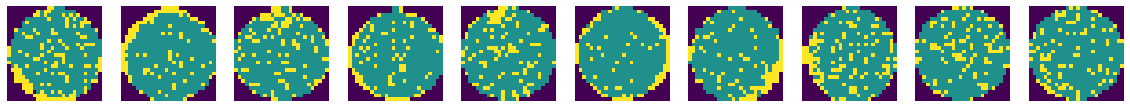

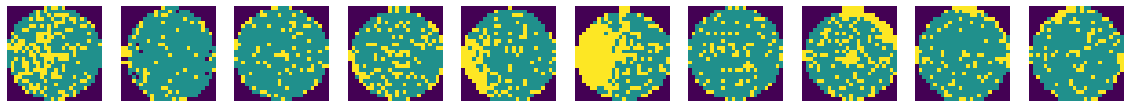

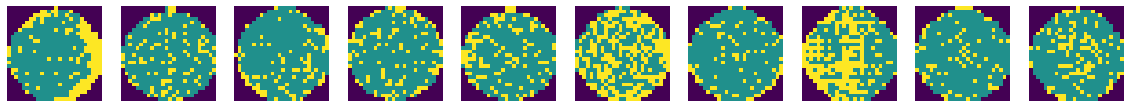

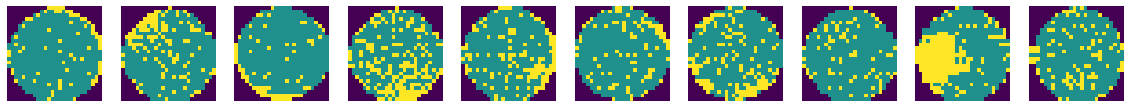

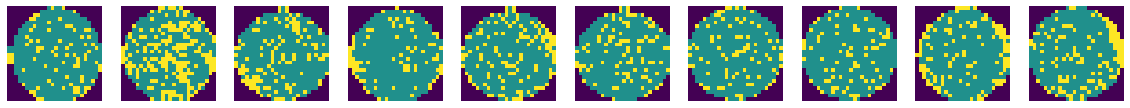

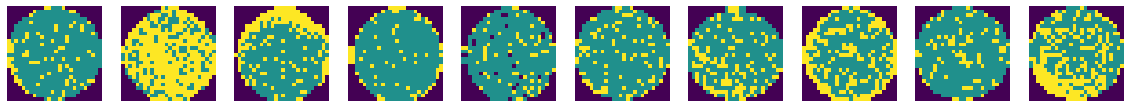

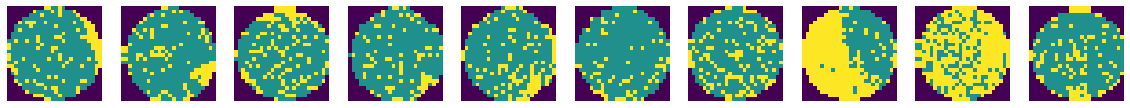

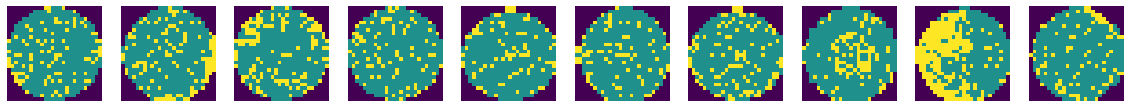

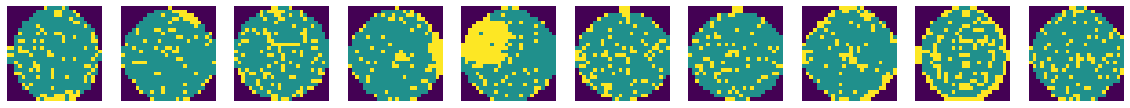

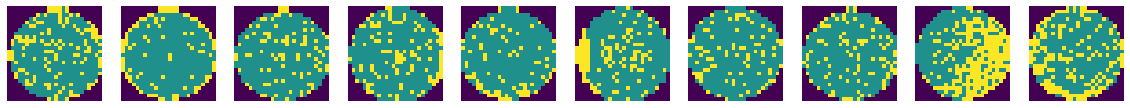

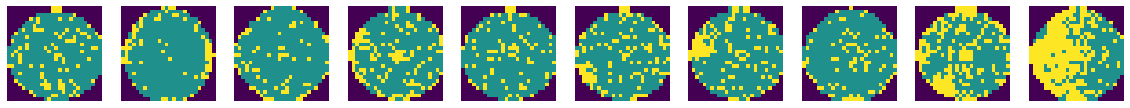

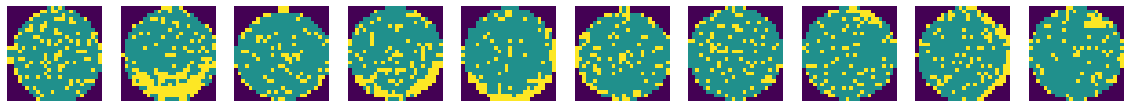

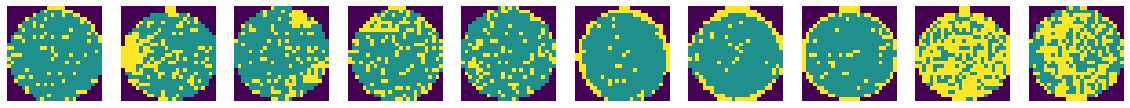

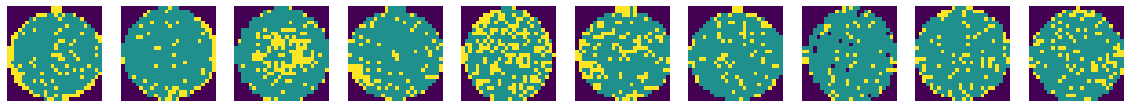

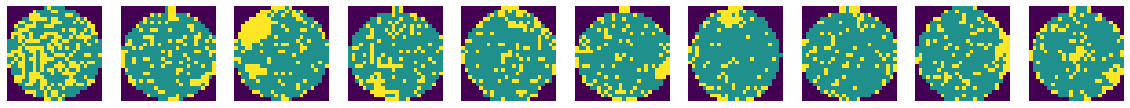

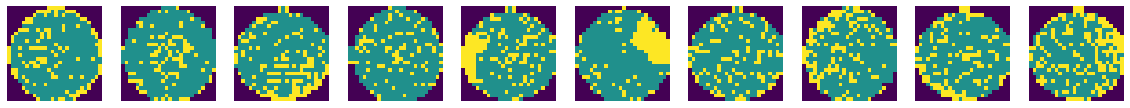

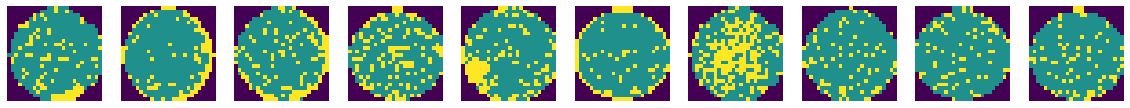

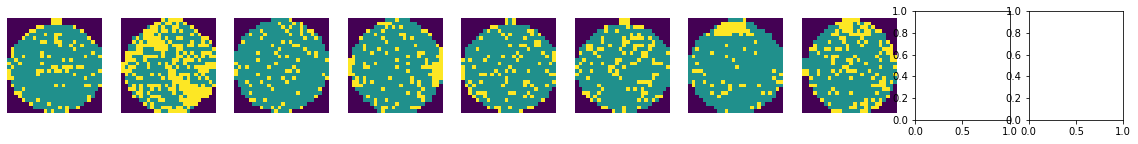

In [138]:
#Visualizing the out of distribution datapoints:
def show_images(x, ncols=10):
    x = x.view(-1, 26, 26)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].detach().numpy())
        ax[idx].axis('off')
    plt.show()

for idx, data in enumerate(ood_dataloader):
    x, y = data
    try:
        show_images(x)
    except IndexError:
        break

In [ ]:
#Now what we can do is update the train set with the production set
#We can do a case analysis for the performance of the classifier

# a) Train on the entire labelled production data + train set --> check the performance
# b) Train on the ood data + train set ---> check the performance



## Part 2: address the data mining objective

Address the *common* data mining objective and document your findings in the report. You are free to use any approach you like. To get started you may read the required reading in the slides on Dataset Shift and follow the cited papers.

<br/>
<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
For this assignment only your report will be graded. While your code will not be graded directly, any results and figures in your report must be generated by your code below.
</div>

In [ ]:
#// BEGIN_TODO [CODE] (0 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [CODE]

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on this assignment?

Assign a number to variable `feedback_time`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_1] (0 points)

#// END_FEEDBACK [Feedback_1]

import numbers
assert isinstance(feedback_time, numbers.Number), "Please assign a number to variable feedback_time"

### How difficult did you find this assignment?

Assign an integer to variable `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_2] (0 points)

#// END_FEEDBACK [Feedback_2]

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to variable feedback_difficulty"

### (Optional) What did you like?

Assign a string to variable `feedback_like`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_5] (0 points)

#// END_FEEDBACK [Feedback_5]

### (Optional) What can be improved?

Assign a string to variable `feedback_improve`. Please be specific, so that we can act on your feedback.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_6] (0 points)

#// END_FEEDBACK [Feedback_6]